In [2]:
import numpy as np

import sys
sys.path.insert(0,r'/home/markus/repos/uni/16ma/bicycle/python')
from models.load_data_set import load_data_set, load_trajectory_dump
from bicycle.plot_bicycle_trajectories import position, state, add_default_reward_info
from bicycle import gp_models
from bicycle import dump_pso_trajectory, dump_trajectory_to_file
from bicycle import reward_functions as rf

In [3]:
import holoviews as hv

hv.notebook_extension()
hv.ipython.display_hooks.ABBREVIATE_TRACEBACKS = False
%output holomap='auto' widgets='embed'
%output size=150 dpi=120 max_frames=1000
%opts Points (s=20) Overlay [legend_position='bottom_left']
%opts Spread (alpha=0.4)
%opts Curve[show_title=True, title_format='{label}']
%opts Overlay[show_title=True show_grid=True title_format='{label}']
%opts Overlay.State[xaxis='bare', yaxis='bare']
%opts GridMatrix[padding=0.25 show_title=False xaxis=None yaxis=None normalize=False shared_xaxis=True] {+framewise}
%opts Layout[show_title=False]

In [4]:
# Used in thesis
start_state = np.array([[ -0.1884464 ,   0.12422539,  -0.52359878,  -1.3556213 , -2.99016603,  17.96012712,   1.32301791]])
actions = np.array([[-0.02      ,  2.        ],
       [-0.02      ,  2.        ],
       [-0.02      ,  2.        ],
       [-0.02      ,  1.52255158],
       [-0.02      , -2.        ],
       [-0.02      , -2.        ],
       [-0.02      , -2.        ],
       [-0.02      , -2.        ],
       [-0.02      , -0.81007316],
       [-0.02      , -2.        ],
       [-0.02      ,  2.        ],
       [-0.02      ,  2.        ],
       [-0.02      ,  2.        ],
       [-0.00525811,  2.        ],
       [ 0.02      ,  1.74532387]])

In [57]:
# Alternative
start_state = np.array([  0.08811214,  -0.49623446,   0.38517847,  -1.44812528,
         0.96419533,  26.67112597,  -2.61914898])
actions = np.array([[ 0.02      , -2.        ],
       [ 0.02      , -2.        ],
       [ 0.02      , -2.        ],
       [ 0.02      , -2.        ],
       [ 0.02      , -2.        ],
       [ 0.02      ,  1.71204729],
       [ 0.01994037,  2.        ],
       [ 0.02      ,  2.        ],
       [-0.02      ,  2.        ],
       [ 0.02      ,  2.        ],
       [ 0.02      ,  2.        ],
       [ 0.00586125, -2.        ],
       [ 0.02      ,  0.11321701],
       [-0.01152808,  2.        ],
       [ 0.00449897,  0.34137663]])

In [6]:
model_dir= r'/home/markus/repos/uni/16ma/bicycle/evals/26/models/evaluation_set/gpy/'
gp_sim = gp_models.GPySimulation(model_dir, ('rbf', 60000, 50))

In [15]:
def to_df(futures):
    return dump_trajectory_to_file.dump_data_frame([futures[0]], [futures[1]], [actions], [futures[2]])[0]

def experiment(posterior, with_truncation=False):
    gp_sim.posterior_method = posterior
    if with_truncation:
        model, simulation = dump_pso_trajectory.create_futures(start_state, actions, gp_sim.evolve_states, 0.01, 10, rf.default_reward().state_posteriors)
    else:
        model, simulation = dump_pso_trajectory.create_futures(start_state, actions, gp_sim.evolve_states, 0.01, 10)
    return simulation, model

In [55]:
def dump_experiment(name, exp):
    simulation_future, model_future = exp
    model_states, model_next_states, model_next_variances = model_future
    simulation_states, simulation_next_states, simulation_next_variances = simulation_future
        
    dump_trajectory_to_file.dump_trajectory_to_file(
        'solution_predictions_{}_model.xa'.format(name),
        model_states, model_next_states, actions,
        model_next_variances
    )
    dump_trajectory_to_file.dump_trajectory_to_file(
        'solution_predictions_{}_simulation.xa'.format(name),
        simulation_states, simulation_next_states, actions,
        simulation_next_variances
    )

b':GridMatrix   [Xignore,Yignore]\n   :Overlay\n      .Curve.Simulation :Curve   [Time]   (y)\n      .Curve.Model      :Curve   [x]   (y)'
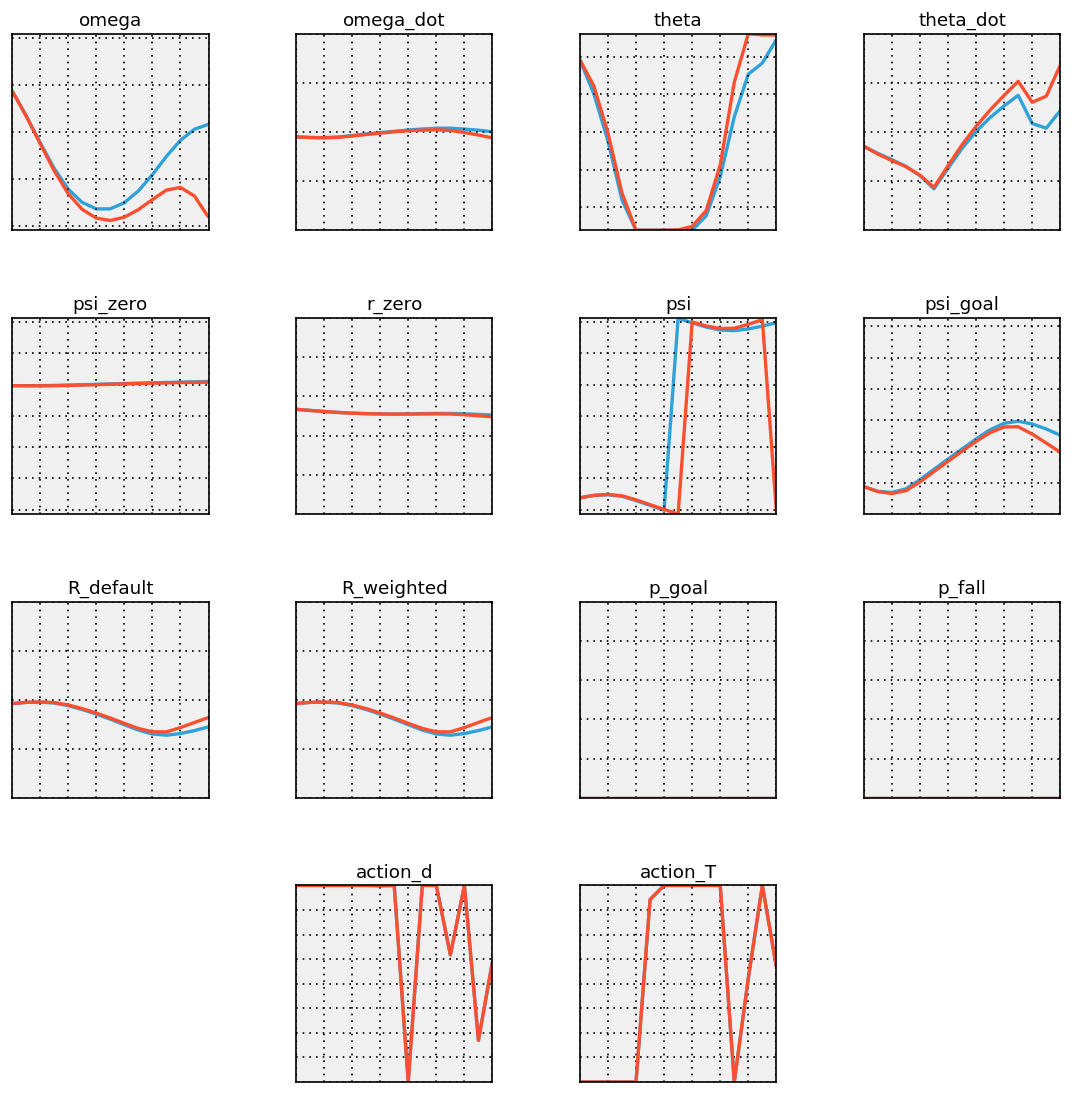

In [58]:
%%output filename="map_predictions" fig="png"

exp = experiment("means_only", False)
dump_experiment("means_only", exp)
hv.GridMatrix(state(*map(to_df, exp)))

b':GridMatrix   [Xignore,Yignore]\n   :Overlay\n      .Curve.Simulation :Curve   [Time]   (y)\n      .Spread.I         :Spread   [x]   (y,yerror)\n      .Curve.Model      :Curve   [x]   (y)\n      .Spread.II        :Spread   [x]   (y,yerror)'
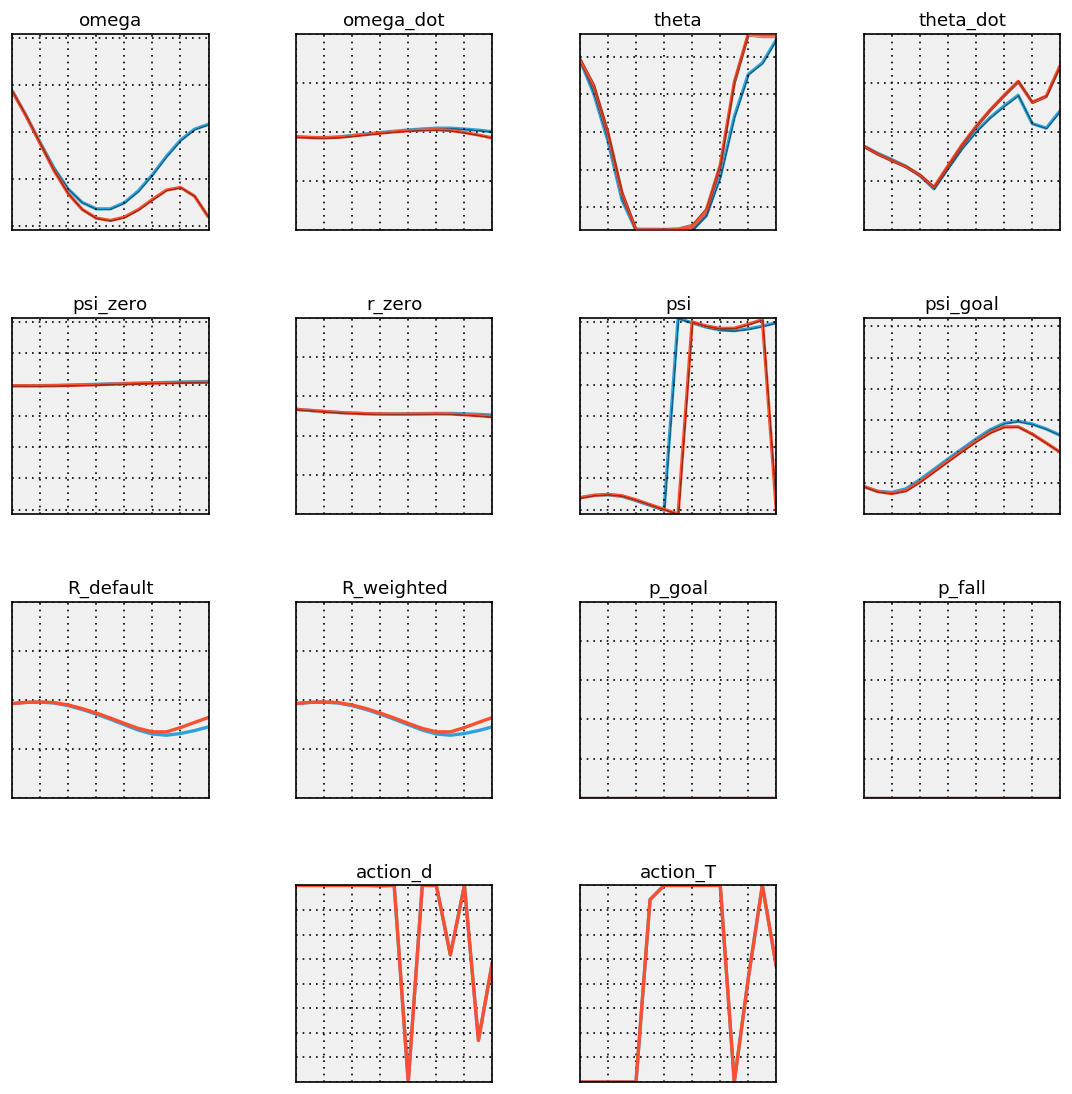

In [59]:
%%output filename="os_predictions" fig="png"

exp = experiment("one_step", False)
dump_experiment("one_step", exp)
hv.GridMatrix(state(*map(to_df, exp)))

b':GridMatrix   [Xignore,Yignore]\n   :Overlay\n      .Curve.Simulation :Curve   [Time]   (y)\n      .Spread.I         :Spread   [x]   (y,yerror)\n      .Curve.Model      :Curve   [x]   (y)\n      .Spread.II        :Spread   [x]   (y,yerror)'
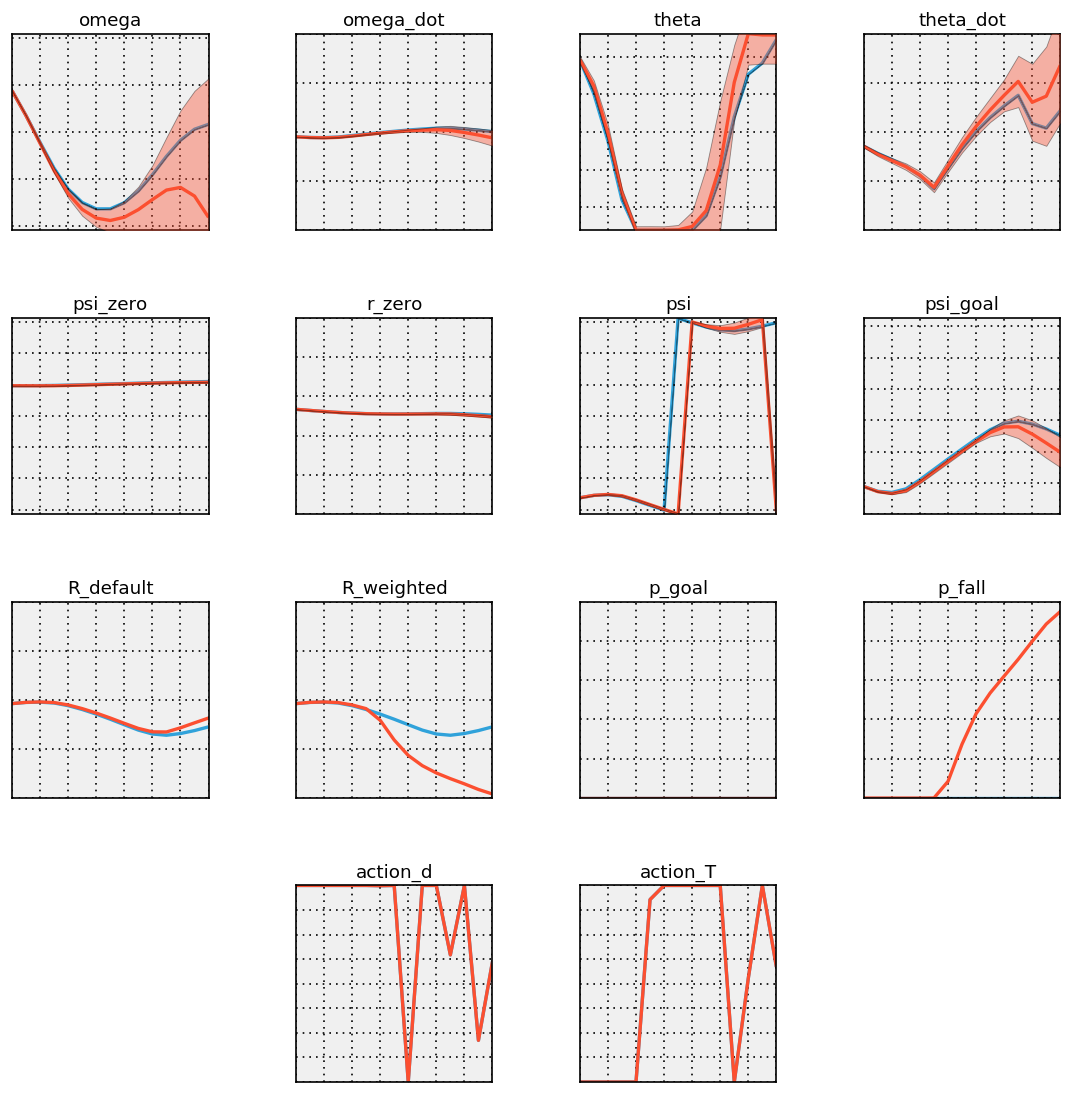

In [60]:
%%output filename="ms_predictions" fig="png"

exp = experiment("linearization", False)
dump_experiment("linearization", exp)
hv.GridMatrix(state(*map(to_df, exp)))

b':GridMatrix   [Xignore,Yignore]\n   :Overlay\n      .Curve.Simulation :Curve   [Time]   (y)\n      .Spread.I         :Spread   [x]   (y,yerror)\n      .Curve.Model      :Curve   [x]   (y)\n      .Spread.II        :Spread   [x]   (y,yerror)'
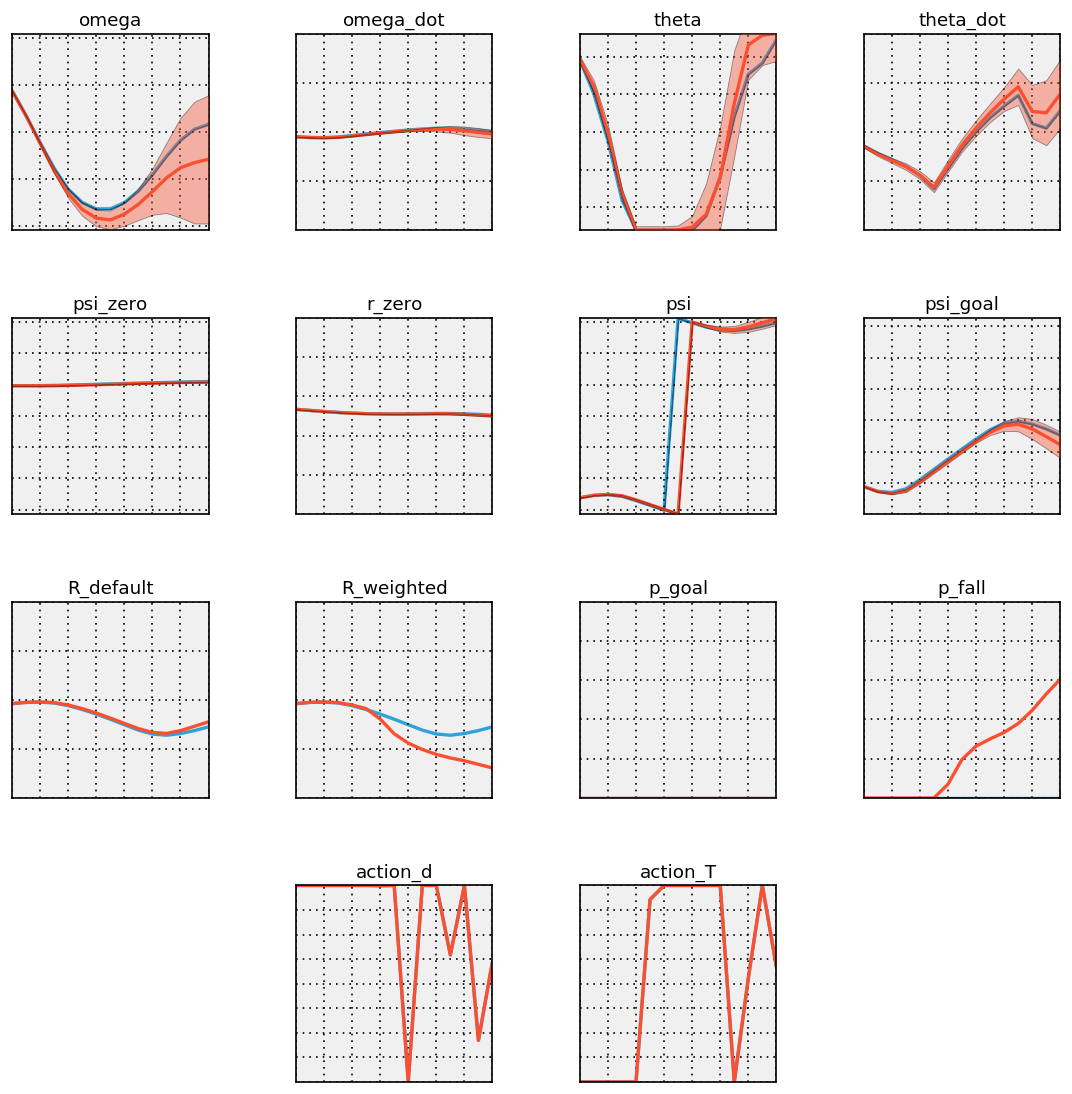

In [61]:
%%output filename="tg_predictions" fig="png"

exp = experiment("linearization", True)
dump_experiment("truncation", exp)
hv.GridMatrix(state(*map(to_df, exp)))